**글쓴이 : 이영노**

**날짜 : 2023/02/18**

# GPT(Generative Pre-trained Transformer) 란?

gpt의 output : 다음에 올 확률이 가장 높은 토큰

gpt의 label : 원래 다음에 와야할 토큰


gpt는 transformer의 decoder구조와 "유사"하지, 동일하지 않다. 이해를 하기 위한 서술일뿐, 

gpt는 attention 메커니즘을 사용한 언어모델이다.


# Fine-Tuning & Few Shot

fine-tuning : 사전학습한 모든 가중치에 더해, 특정 task 를 위한 최소한의 가중치를 추가해서, 모델을 추가로 학습하는 방법

few shot : 정답 레이블이 있는 예제를 주고, 추론하려는 Query의 결과를 완성하도록 하는 방법 (GPT-3)


Few Shot 외에도 One Shot, Zero Shot 이 있다. One Shot 은 Few Shot과 동일하지만 오직 하나의 예시만을 주는 경우이다. 

Zero Shot은 문제에 대한 예시는 주지 않고, 문제를 설명하는 자연어 문구만을 준다. 

문제상황을 어떻게 해결하라고 지시하면, 그걸 학습하는 것.


# I. Tokenize

1. Word Tokenize : BOW방식으로 각 단어에 index 부여

- Vocab: 모든 단어에 index 부여할 수 없기 때문에, 모델이 처리할 수 있는(아는) 단어를 정해줌. 이를 Vocab 이라고 함.

- `<unk>`: OOV

2. Sub-Word Tokenize : 한 단어를/ 여러 토큰으로/ 분리하여 tokenize

- BERT : Word-piece 방식

- GPT : Sentence-piece 방식




Subword Tokenizer는 "나" 가 동일한 토큰인 "_나"로 처리되면서

**Word Tokenizer의 단어의 변형에 대응하지 못해서, 비슷한 단어들의 연관성이 사라지는 문제를 해결하고 있다.**

**동시에 한 단어를 분리하여 Tokenize 함으로써 OOV (Out Of Vocabulary) 에 더욱 잘 대응할 수 있게 되는 장점을 가지고 있다.**

**<GPT의 구조>**

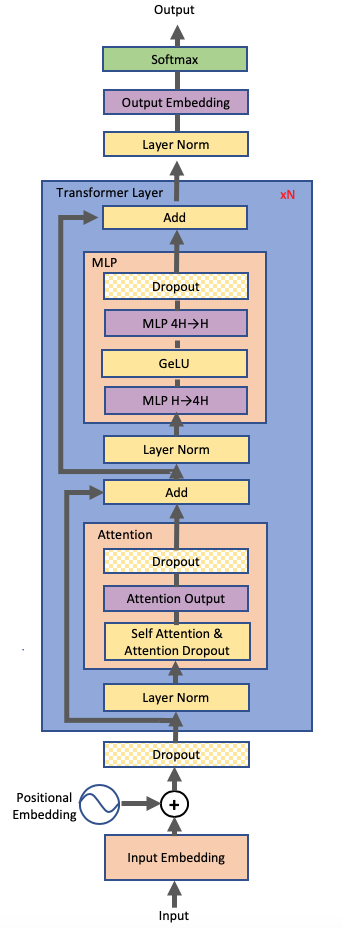

# II. Input

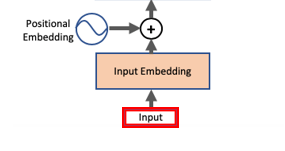

## II-1. Input index & Token index

GPT의 사전학습은 auto-regressive 하게 이루어지기 때문에, 대화 자체가 레이블된 데이터임. 따라서 사전학습 과정에 있어서 따로 레이블링은 필요없음.

그러나 auto-regression 에서 최적의 lag를 설정해서 예측하는 만큼, GPT도 유사하게 특정 참고할 시점을 설정해서 예측함. 이때 이 특정 참고할 시점의 길이를 **Window Size**라고 함.

⭐ Window Size : 한 Input에서 토큰의 개수

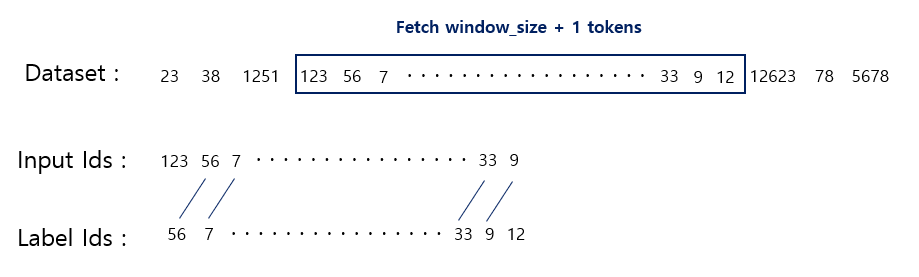

해당 window size를 가진 sample들을 batch_size만큼 가져와서 하나의 batch를 생성함.

⭐ 따라서 Input index, Label index의 shape은 [batch_size, sequence_length] 이다.

(참고로 sequence_length = window size)

⭐ 모델에는 input index가 들어가고, 여기서 logit해준 다음에, label index와 비교함.



## II-2. Future Mask (Attention Mask)

GPT에서는 다음에 올 단어를 예측할때, 이전 단어들의 attention만을 사용한다.

따라서 뒤에 오는 단어들을 가린다. 

⭐ Future Mask : 각각의 모든 단어가, 다른 단어들에 대해, mask하는지 여부를 T/F로 표현한 행렬

# III. Vectorization (Embedding)

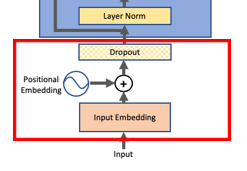

## III-1. Token Embedding

torch.nn.Embedding() 으로 구현되는데, dense representation이고, 

random 초기값에서 시작해, 훈련과정에서 학습되는 vector다. (lookup table 업데이트)

Size : [batch_size, sequence_length, hidden_size=1600]

## III-2. Position Embedding

해당 단어의 위치가 어디있는지 알려주는 정보

input의 차원은 단어의 개수이다.(sequence_length). 각 단어들의 위치가 문장내 단어의 개수의 범위안에 존재하기 때문.

Size: [batch_size, sequence_length, hidden_size]

## III-3. Dropout

p의 확률로 input tensor의 값이 0으로 바뀜. 

Overfitting을 방지하기 위한 목적.**(Vectorization 과정에서)**

⭐ **Final Embedding Vector = Dropout(Token Embedding + Position Embedding)**

# IV. Transformer Layer

## IV-1. Layer Normalization (Not Batch!)

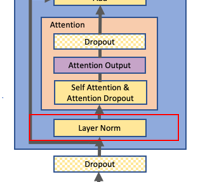


layer를 normalize(정규화)하여 서로 다른 layer끼리 영향을 미치지 않게 하기 위함. 또한 학습 수렴도 빨라짐.

⭐ 배치 Normalization 과의 차이?

- Batch Normalization : feature단위로 평균, 표준편차 계산해서 정규화.

- Layer Normalization : data sample단위로 평균, 표준편차 계산해서 정규화

For more infos...
https://www.pinecone.io/learn/batch-layer-normalization/

## IV-2. Masked Multi-Head Self Attention

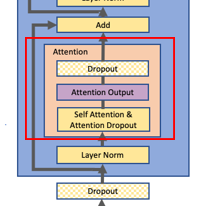

Input(Query, Key, Value) Size : [batch_size, sequence_length, hidden_size]

## IV-3. Skip Connection (Add) , Layer Normalization

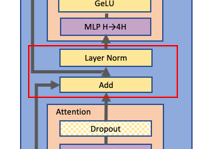

Masked Multi-Head Attention 화 된 벡터 + 기존 original input 벡터 를 더함.

## IV-4. Position-wise Feed Forward Neural Network

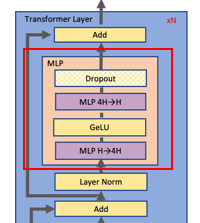

벡터의 차원을 "늘였다", "줄였다" 하는 작업.

In [1]:
import torch.nn as nn
 
class PositionWiseFeedForward(nn.Sequential):
 
    def __init__(self, dims: int, rate: int = 4, dropout: float = 0.1):
        super().__init__(
            nn.Linear(dims, dims * rate),  # (b, s, 4 * h)
            gelu(),  # Activation Function
            nn.Dropout(dropout),
            nn.Linear(dims * rate, dims))  # (b, s, h)

GeLU 말고 Swish 가 성능이 좋다는 견해도 있음.


In [3]:
import torch
import torch.nn as nn
 
 
class Swish(nn.Module):
 
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x * self.sigmoid(x)
 
        return x

# V. Prediction

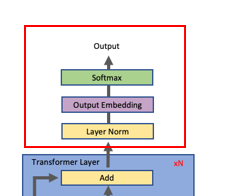

Input layer/ Transformer layer를 거친 벡터가 반환됨.

**이제 이 벡터를 사용하여 다음 단어를 예측하기 위해서는 "다음에 올 단어가", 모델에 존재하는 단어(Vocab)가 될 확률을 구해야 됨.**

이는 Output Embedding 과 Softmax를 사용한다.

 Output Size : [batch_size, sequence_length, hidden_size]

## V-1. Output Embedding

hidden_size(hidden layer dimension)의 벡터 --> vocab_size의 logit으로 변환

이때 Token Embedding 의 가중치가 사용됨.

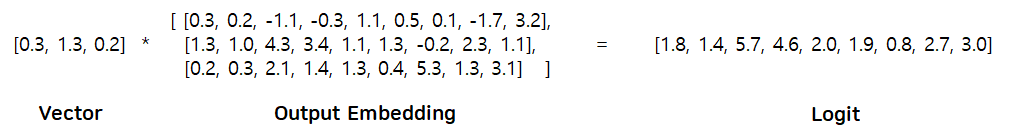

## V-2. Softmax

softmax한 value ~ label index : LOSS를 계산(CrossEntropyLoss)